# Fully Convolutional Neural Networks

### Goal of this notebook:

Re-architecture a pre-trained image classification model to compute a low resolution dogness map for any input image (poor's man semantic segmentation).

### Educational objectives:

- Load a CNN model pre-trained on ImageNet from the [timm library](https://huggingface.co/docs/timm/index)
- Preprocess a test image to make it match the expected input format of the trained model
- Interpret the meaning of the ImageNet classes with the WordNet ontology
- Transform the image classification network into a Fully Convolutional Network
- Apply the network to perform weak segmentation on a test image

In [77]:
%pip install -q timm torchinfo pillow nltk

Note: you may need to restart the kernel to use updated packages.


In [78]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Loading a baseline pre-trained ResNet from timm

[timm](https://github.com/rwightman/pytorch-image-models) is a very well maintained library of pre-trained computer vision models for PyTorch.

In the following the name `resnet18d` stands for a 18 layer network with the ResNet architecture. The `d` is an identifier for [modernized variant](https://arxiv.org/abs/1812.01187) of the original ResNet.

In [79]:
import timm

model = timm.create_model("resnet18d", pretrained=True).to(device)
model.eval()  # we will no train this model for this study

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
   

In [80]:
model(torch.randn(1, 3, 224, 224).to(device)).shape

torch.Size([1, 1000])

## Question

- Why does the model output has this shape?

## The ImageNet classes

The 1000 classes of the ImageNet 1K dataset are a subset of the concepts of the WordNet ontology. Each concept is name a "synset" and are organized in a hierarchical ontology with higher level concepts (e.g. "animal") and more specialized concepts (e.g. "corgi") with intermediate concept in the hierarchy (e.g. "dog").

Let's find all the dog concepts from WordNet that appear on ImageNet 1K (aka the list of classes from the 2012 challenge). For reference here is a ist of synset identifiers and English class names:

- https://www.image-net.org/challenges/LSVRC/2012/browse-synsets.php

Let's build something similar by downloading the full ontology from the `nltk` package to get the class hierarchy data.

In [81]:
import nltk
from nltk.corpus import wordnet as wn

nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [82]:
[s for s in wn.all_synsets("n") if "dog" in s.lemma_names()]

[Synset('dog.n.01'),
 Synset('andiron.n.01'),
 Synset('pawl.n.01'),
 Synset('frank.n.02'),
 Synset('cad.n.01'),
 Synset('dog.n.03'),
 Synset('frump.n.01')]

In [83]:
dog_synset = wn.synset("dog.n.01")
dog_synset.definition()

'a member of the genus Canis (probably descended from the common wolf) that has been domesticated by man since prehistoric times; occurs in many breeds'

In [84]:
dog_synset.lemma_names()

['dog', 'domestic_dog', 'Canis_familiaris']

In [85]:
wn.synset("dog.n.02").definition()

'a dull unattractive unpleasant girl or woman'

In [86]:
wn.synset("dog.n.03").definition()

'informal term for a man'

In [87]:
def synset_id(synset):
    return f"{synset.offset():08d}-{synset.pos()}"


synset_id(dog_synset)

'02084071-n'

In [88]:
dog_descendants = dog_synset.closure(lambda s: s.hyponyms())
dog_descendant_ids = {synset_id(s) for s in dog_descendants}
len(dog_descendant_ids)

189

In [89]:
import json
from pathlib import Path
from urllib.request import urlretrieve


imagenet_to_synset_path = Path("imagenet_label_to_wordnet_synset.json")
imagenet_to_synset_url = "https://gist.githubusercontent.com/Juanvulcano/381b740a4eb8d46229b31fbdbdce01b1/raw/b49d3828a656eb41bc07426b5f7416722604a6c2/imagenet_label_to_wordnet_synset.json"

if not imagenet_to_synset_path.exists():
    urlretrieve(imagenet_to_synset_url, imagenet_to_synset_path)

imagenet_metadata = {
    int(key): value
    for key, value in json.loads(imagenet_to_synset_path.read_text()).items()
}
class_synsets = {k: v['id'] for k, v in imagenet_metadata.items()}
class_labels = {k: v['label'] for k, v in imagenet_metadata.items()}

In [90]:
dog_class_ids = [
    class_id
    for class_id, synset_id in class_synsets.items()
    if synset_id in dog_descendant_ids
]
len(dog_class_ids)

118

In [91]:
for class_id in dog_class_ids[:10]:
    print(f"[{class_id:03d}] {class_labels[class_id]}")

print("...")


[151] Chihuahua
[152] Japanese spaniel
[153] Maltese dog, Maltese terrier, Maltese
[154] Pekinese, Pekingese, Peke
[155] Shih-Tzu
[156] Blenheim spaniel
[157] papillon
[158] toy terrier
[159] Rhodesian ridgeback
[160] Afghan hound, Afghan
...


## A test image

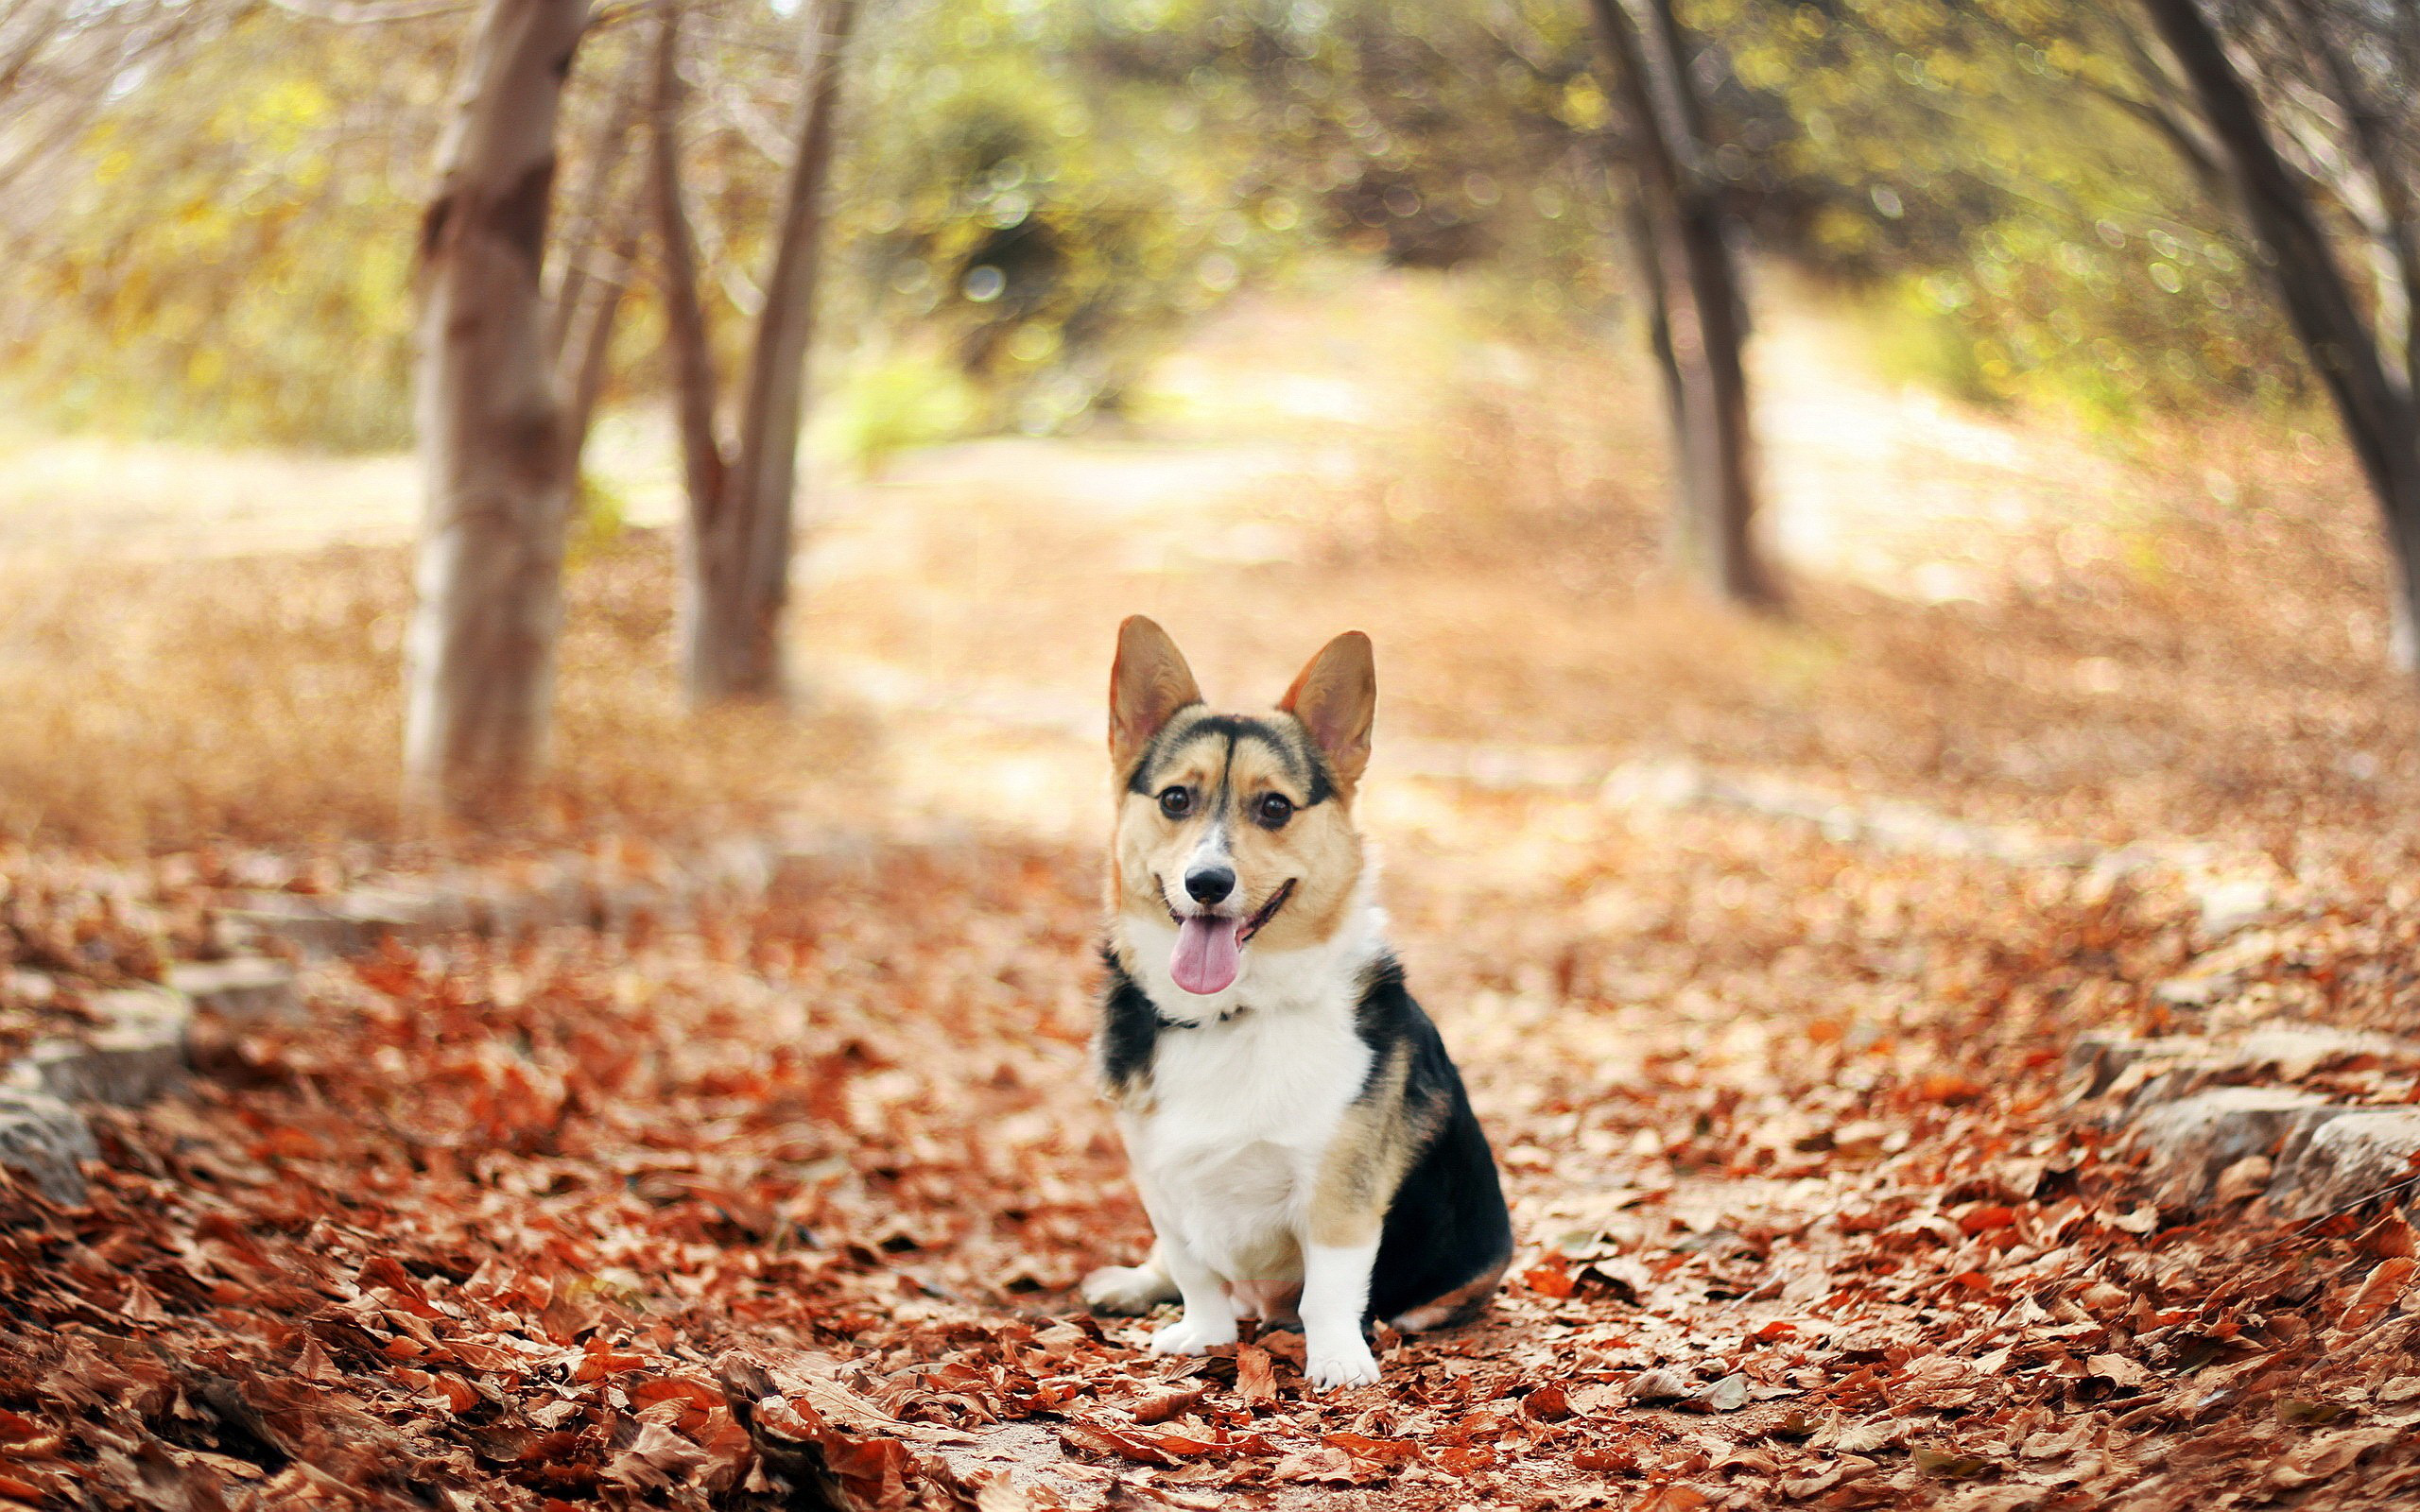

In [92]:
from urllib.request import urlretrieve
from pathlib import Path
from PIL import Image


dog_url = "https://raw.githubusercontent.com/m2dsupsdlclass/lectures-labs/master/labs/05_conv_nets_2/dog.jpg"
dog_path = Path("dog.jpg")

if not dog_path.exists():
    urlretrieve(dog_url, dog_path)


# Load the image file:
dog_img = Image.open(dog_path)
dog_img

In [93]:
import numpy as np

np.array(dog_img).shape

(1600, 2560, 3)

In [94]:
np.array(dog_img).dtype

dtype('uint8')

In [95]:
# np.array(dog_img)

## Questions:

In the previous cells we observe that `pillow.Image` decodes JPEG files as 3D arrays of unsigned integers of 8 bits each (`uint8`).

- What is the meaning of each of the 3 axes (dimensions) of the array?
- What is the advantage of using `uint8` instead of `uint32` or `int32`?
- What is are the minimum and maxium values that can be coded with `uint8`?


Note that this image has quite a large resolution and does not match the distribution of the pixel values used during the training procedure. Let's load the preprocessing pipeline typically used by timm models:

In [96]:
# new_size = (300, 500)
new_size = 224
image_preprocessor = timm.data.transforms_factory.create_transform(new_size)
image_preprocessor

Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

In [97]:
dog_tensor = image_preprocessor(dog_img).to(device)
dog_tensor

tensor([[[-0.0972,  0.0227,  0.3652,  ...,  0.7248,  0.6563,  0.6734],
         [-0.0801,  0.0741,  0.4679,  ...,  0.4508,  0.4337,  0.5193],
         [-0.0116,  0.1426,  0.4851,  ...,  0.4166,  0.3138,  0.3138],
         ...,
         [ 0.4337,  0.9303,  1.3070,  ...,  0.0741,  0.0741,  0.1083],
         [ 1.3755,  1.5982,  1.6495,  ..., -0.3541, -0.4226, -0.5767],
         [ 1.6153,  1.4954,  1.1358,  ..., -0.1143,  0.2282, -0.1828]],

        [[-0.4426, -0.3550, -0.0049,  ...,  0.5378,  0.4853,  0.5203],
         [-0.3901, -0.2850,  0.1176,  ...,  0.2577,  0.2752,  0.3452],
         [-0.3725, -0.2150,  0.1176,  ...,  0.2052,  0.1176,  0.1176],
         ...,
         [-0.6877,  0.3452,  0.8529,  ..., -1.1954, -1.0378, -0.8627],
         [ 1.0105,  1.2731,  1.2731,  ..., -1.4055, -1.1078, -1.3179],
         [ 1.2906,  1.0630,  0.5203,  ..., -0.9503, -0.2850, -0.7577]],

        [[-0.4450, -0.3927, -0.3055,  ..., -0.2010, -0.1835, -0.0790],
         [-0.4101, -0.3578, -0.2010,  ..., -0

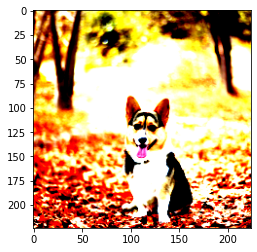

In [98]:
import matplotlib.pyplot as plt

_ = plt.imshow(dog_tensor.permute(1, 2, 0).cpu())

## Exercise

Try to inspect the last transform of `image_preprocessor` to recover the shift (`.mean`) and scale (`.std`) and inverse the normalization of the pixel intensity values to be able to plot the true colors with matplotlib.

In [99]:
# TODO: put your code here

# Hint: you can access the last transform as follows:
last_step = image_preprocessor.transforms[-1]












## Solution

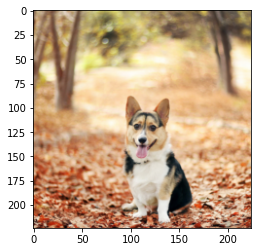

In [100]:
n = image_preprocessor.transforms[-1]
_ = plt.imshow((dog_tensor.cpu().permute(1, 2, 0) * n.std) + n.mean)

In [101]:
dog_tensor.unsqueeze(axis=0).shape

torch.Size([1, 3, 224, 224])

In [102]:
with torch.no_grad():
    dog_logits = model(dog_tensor.unsqueeze(axis=0))
dog_logits.shape

torch.Size([1, 1000])

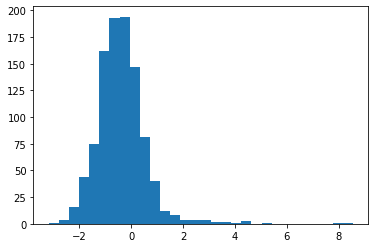

In [103]:
_ = plt.hist(dog_logits.cpu(), bins=30)

## Exercise

- use `torch.nn.Softmax` to post process the `dog_logits` and  turn them into class probabilities that sum to one;
- try to find the integer index of the classes with the 5 highest probabilities (hint: use the `argsort` method of torch or numpy);
- (Optional) write a function named `decode_predictions` that prints the class labels and probabilites of top 5 predictions of the model;
- compute the probability that this is a picture of "any" doc by using the set of `dog_class_ids` computed from the WordNet hierarchy.

In [104]:
# TODO: write your code here
















# and do not cheat by looking at the solution below before executing your code ;)

## Solution

In [105]:
with torch.no_grad():
    dog_probs = torch.nn.Softmax(dim=1)(dog_logits)
dog_probs.shape

torch.Size([1, 1000])

In [106]:
dog_probs.min()

tensor(4.0550e-06, device='cuda:0')

In [107]:
dog_probs.max()

tensor(0.5070, device='cuda:0')

In [108]:
dog_probs.sum(axis=1)

tensor([1.], device='cuda:0')

In [109]:
dog_probs[0].argsort(descending=True)[:5]

tensor([263, 264, 253, 227, 162], device='cuda:0')

And here is a Python function to decode the individual class predictions (only display the most likely classes):

In [110]:
def decode_predictions(logits, topk=5, min_prob_threshold=0.05):
    probs = torch.nn.Softmax(dim=1)(logits)
    for class_id in dog_probs[0].argsort(descending=True)[:topk]:
        class_id = class_id.item()
        prob = probs[0, class_id].item()
        valid_marker = "✓" if prob >= min_prob_threshold else "✗"
        print(f"{valid_marker} {prob:.3f} [{class_id}]: {class_labels[class_id]}")


decode_predictions(dog_logits)

✓ 0.507 [263]: Pembroke, Pembroke Welsh corgi
✓ 0.335 [264]: Cardigan, Cardigan Welsh corgi
✗ 0.019 [253]: basenji
✗ 0.009 [227]: kelpie
✗ 0.008 [162]: beagle


Let's sum the all the probabilities that correspond to dog classes to get the "any dog" probability:

In [111]:
any_dog_prob = 0.0
for class_id in range(dog_probs.shape[1]):
    if class_id in dog_class_ids:
        any_dog_prob += dog_probs[0, class_id].item()
print(any_dog_prob)

0.9216085494572326


Alternatively we can do this using torch vector operations as follows:

In [112]:
dog_class_mask = torch.zeros(1000).to(device)
dog_class_mask[dog_class_ids] = 1.0
assert dog_class_mask.sum().item() == len(dog_class_ids)

(dog_probs[0] * dog_class_mask).sum().item()

0.9216085076332092

## A bit of Network Surgery

The objective of this section is to compute the "any dog" probability map on each sub-regions of the image.

To do so we will explore how the layers and feature maps of the pre-trained network are structured in more details and we will then find a way to re-architecture the network to automatically compute our probability map **without retraining the weights**.

Let's have a look at the raw PyTorch structure of the model first, in particular on the last layers and the layers with `stride` with value `(2, 2)`.

In [113]:
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
   

Now let's use `torchinfo` to compute the output-shape of the feature map for a given input image size:

In [114]:
dog_tensor.shape

torch.Size([3, 224, 224])

In [115]:
import torchinfo

torchinfo.summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Sequential: 1-1                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 32, 112, 112]         864
│    └─BatchNorm2d: 2-2                  [1, 32, 112, 112]         64
│    └─ReLU: 2-3                         [1, 32, 112, 112]         --
│    └─Conv2d: 2-4                       [1, 32, 112, 112]         9,216
│    └─BatchNorm2d: 2-5                  [1, 32, 112, 112]         64
│    └─ReLU: 2-6                         [1, 32, 112, 112]         --
│    └─Conv2d: 2-7                       [1, 64, 112, 112]         18,432
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └

## Questions:

- What does the `1` value in the first axis of the output shape mean?
- Which layers **do not** preserve any spatial (height and width) structure of the original input image?
- How does the spatial resolution evolves over time? Which layer are responsible for these changes?
- Try to change the dimension of the input image passed to `torchinfo.summary` in the cell above and observe the impact on the output shape.

## Architecture change for pre-trained semantic segmentation

- Step 1: extract the convolutional stem of the network: all layers before the final average pooling layer,
- Step 2: extract the weights of the final classification layer,
- Step 3: create a new 1x1 Convolutional layer with 1000 output channels and the weights of the previous classfication layer,
- Step 4: apply the 1x1 convolutational to random input data and normalize the output using softmax,
- Step 5: sum all the probabilities for the doc class,
- Step 6: assemble all the previous steps into a fully convolutional model with the convolutional stem, the classification convolutional layer and optionally a final softmax layer to normalize the predictions a probabilities while preserving the spatial structure of the output of the network.

Let's explore the first steps together and then you will assemble the full architecture as an exercise:


- Step 1: extract the convolutional stem of the network: all layers before the final average pooling layer,

In [116]:
len(list(model.children()))

10

In [117]:
conv_stem = torch.nn.Sequential(*list(model.children())[:-2])
conv_stem(torch.randn(1, 3, 224, 224).to(device)).shape

torch.Size([1, 512, 7, 7])

- Step 2: extract the weights of the final classification layer,

In [118]:
linear_classifier = list(model.children())[-1]
linear_classifier

Linear(in_features=512, out_features=1000, bias=True)

In [119]:
linear_classifier.weight.shape

torch.Size([1000, 512])

In [120]:
linear_classifier.bias.shape

torch.Size([1000])

- Step 3: create a new 1x1 Convolutional layer with 1000 output channels and the weights of the previous classfication layer,


In [121]:
conv_classifier = torch.nn.Conv2d(512, 1000, kernel_size=1, bias=True)
conv_classifier.weight.shape

torch.Size([1000, 512, 1, 1])

In [122]:
conv_classifier.bias.shape

torch.Size([1000])

Let's load the parameters of the pre-trained linear classification layer into our newly created 1x1 convolutional layer:

In [123]:
conv_classifier.weight = torch.nn.Parameter(
    linear_classifier.weight.reshape([1000, 512, 1, 1])
)
conv_classifier.bias = torch.nn.Parameter(linear_classifier.bias)

conv_output = conv_classifier(torch.randn(1, 512, 7, 7).to(device))
conv_output.shape

torch.Size([1, 1000, 7, 7])

- Step 4: apply the 1x1 convolutational to random input data and normalize the output using softmax,

In [124]:
normalized_conv_output = torch.softmax(conv_output, axis=1)
normalized_conv_output.shape

torch.Size([1, 1000, 7, 7])

- Step 5: sum all the probabilities for the doc class,

In [125]:
dogness_conv_output = (normalized_conv_output * dog_class_mask.reshape(1, 1000, 1, 1)).sum(axis=1)
dogness_conv_output.shape

torch.Size([1, 7, 7])

## Exercise

Step 6: assemble all the previous steps into a fully convolutional model with the convolutional stem, the classification convolutional layer and optionally a final softmax layer to normalize the predictions a probabilities while preserving the spatial structure of the output of the network.

Assemble all the components into a new network architecture that takes an preprocessed image tensor of any resolution as input and outputs the probability for each region to be dog-related.

In [126]:
class DoggoProbabilisticMapper(torch.nn.Module):

    def __init__(self, model, dog_class_mask):
        super().__init__()

        # TODO: initialize the submodules here

    def forward(self, x):
        # TODO: compute the probabilistic map here.
        return x # replace me!



# Sample code to check that the model works on our `dog_tensor` input image:

# dog_mapper = DoggoProbabilisticMapper(model, dog_class_mask)

# with torch.no_grad():
#     dog_prob_map = dog_mapper(dog_tensor.unsqueeze(axis=0))

# dog_prob_map.shape

In [127]:
# Use plt.imshow to visualize the probabilistic map.






In [128]:
# Bonus: try to recompute the map for different input image sizes.










## Solution

In [129]:
class DoggoProbabilisticMapper(torch.nn.Module):

    def __init__(self, model, dog_class_mask):
        super().__init__()
        self.conv_stem = torch.nn.Sequential(*list(model.children())[:-2])

        linear_classifier = list(model.children())[-1]
        self.conv_classifier = torch.nn.Conv2d(
            512, 1000, kernel_size=1, bias=True
        )
        self.conv_classifier.weight = torch.nn.Parameter(
            linear_classifier.weight.reshape([1000, 512, 1, 1])
        )
        self.conv_classifier.bias = torch.nn.Parameter(linear_classifier.bias)
        self.dog_class_mask = dog_class_mask

    def forward(self, x):
        x = self.conv_stem(x)
        x = self.conv_classifier(x)
        x = torch.softmax(x, axis=1)
        # Sum all the dog probabilities together.
        return (x * dog_class_mask.reshape(1, 1000, 1, 1)).sum(axis=1)


dog_mapper = DoggoProbabilisticMapper(model, dog_class_mask)

with torch.no_grad():
    dog_prob_map = dog_mapper(dog_tensor.unsqueeze(axis=0))

dog_prob_map.shape

torch.Size([1, 7, 7])

In [130]:
dog_prob_map.min(), dog_prob_map.max()

(tensor(0.0032, device='cuda:0'), tensor(1., device='cuda:0'))

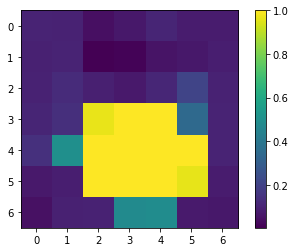

In [131]:
plt.imshow(dog_prob_map[0].cpu())
_ = plt.colorbar()

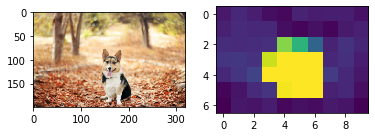

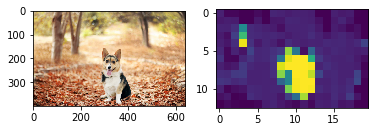

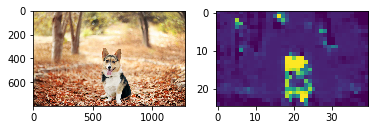

In [132]:
with torch.no_grad():
    for img_size in [(200, 320), (400, 640), (800, 1280)]:
        dog_tensor = timm.data.transforms_factory.create_transform(img_size)(dog_img).to(device)
        dog_prob_map = dog_mapper(dog_tensor.unsqueeze(axis=0))
        fig, (ax0, ax1) = plt.subplots(ncols=2)
        ax0.imshow(dog_tensor.cpu().permute(1, 2, 0) * n.std + n.mean, interpolation="none")
        ax1.imshow(dog_prob_map.cpu().squeeze(), interpolation="none")

To experiment forward, try to adapt this approach to other (convolutional) architectures:

In [133]:
# timm.list_models("*")